# Predict

In [2]:
import pandas as pd
from katlas.train import *
from katlas.dnn import *
from fastai.vision.all import *
from katlas.pssm import *

In [3]:
pspa_unk = pd.read_parquet('out/kd_similar_pspa.parquet')
pspa_unk = pspa_unk[pspa_unk.within_threshold].copy()

In [7]:
len(pspa_unk)

1230

In [4]:
# from katlas.data import *

# kd = Data.get_kd_uniprot()

In [5]:
t5 = pd.read_parquet('out/uniprot_kd_t5.parquet')

In [6]:
test_pspa = t5.loc[pspa_unk.index].reset_index()

## Predict

In [8]:
sample=pd.read_parquet('train/pspa_t5.parquet')

In [9]:
target_col = sample.columns[~sample.columns.str.startswith('T5')]

In [10]:
target_col

Index(['-5P', '-4P', '-3P', '-2P', '-1P', '0P', '1P', '2P', '3P', '4P',
       ...
       '-5pY', '-4pY', '-3pY', '-2pY', '-1pY', '0pY', '1pY', '2pY', '3pY',
       '4pY'],
      dtype='object', length=230)

In [11]:
feat_col = test_pspa.columns[1:]

In [12]:
feat_col

Index(['T5_0', 'T5_1', 'T5_2', 'T5_3', 'T5_4', 'T5_5', 'T5_6', 'T5_7', 'T5_8',
       'T5_9',
       ...
       'T5_1014', 'T5_1015', 'T5_1016', 'T5_1017', 'T5_1018', 'T5_1019',
       'T5_1020', 'T5_1021', 'T5_1022', 'T5_1023'],
      dtype='object', length=1024)

In [13]:
n_feature = len(feat_col)
n_target = len(target_col)

In [14]:
n_feature,n_target

(1024, 230)

In [15]:
def get_cnn(): return PSSM_model(n_feature,n_target,model='CNN')

In [16]:
from tqdm import tqdm

In [17]:
def get_ensemble_pred(test_df, model_name,nfold=5):
    ensemble = None
    for i in tqdm(range(nfold)):
        test_pred = predict_dl(test_df, 
                   feat_col, 
                   target_col,
                   model_func=get_cnn, # model architecture
                   model_pth=f'{model_name}_fold{i}', # only name, not with .pth
                  )
        if ensemble is None:
            ensemble = test_pred.copy()   # start with first prediction
        else:
            ensemble += test_pred         # accumulate
    
    ensemble /= 5
    return ensemble

In [18]:
pred = get_ensemble_pred(test_pspa,'cnn_pspa')

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


In [19]:
pred.index=pspa_unk.index

In [20]:
pred

,-5P,-4P,-3P,-2P,-1P,0P,1P,2P,3P,4P,...,-5pY,-4pY,-3pY,-2pY,-1pY,0pY,1pY,2pY,3pY,4pY
index,,,,,,,,,,,,,,,,,,,,,
A0A8I3S724_AURKA_CANLF_KD1,0.040392,0.043895,0.046737,0.019540,0.037149,0.000031,0.013868,0.034600,0.045904,0.048371,...,0.045335,0.038903,0.040024,0.013075,0.061543,2.734908e-06,0.034069,0.046313,0.060886,0.053116
A0A8I5ZNK2_OXSR1_RAT_KD1,0.050996,0.048736,0.043911,0.027969,0.027601,0.000016,0.012781,0.032713,0.051168,0.052036,...,0.063858,0.052637,0.044536,0.045119,0.063280,1.627727e-06,0.024475,0.023417,0.039241,0.031538
A0JM20_TYRO3_XENTR_KD1,0.050046,0.051092,0.050607,0.050222,0.040077,0.000006,0.014848,0.037900,0.043439,0.043686,...,0.048447,0.052223,0.054218,0.048688,0.092844,9.998993e-01,0.068541,0.070969,0.022715,0.044939
A0JNB0_FYN_BOVIN_KD1,0.047442,0.047701,0.041633,0.049929,0.032297,0.000022,0.014933,0.037427,0.044749,0.045341,...,0.057909,0.067856,0.069088,0.058745,0.070600,9.996487e-01,0.113607,0.103748,0.031480,0.042410
A0M8R7_MET_PAPAN_KD1,0.047693,0.051185,0.049119,0.049185,0.031334,0.000003,0.013425,0.036857,0.050250,0.047437,...,0.056834,0.070674,0.065869,0.060971,0.138563,9.999444e-01,0.098009,0.076506,0.025971,0.043026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z2R9_E2AK1_MOUSE_KD1,0.031652,0.028180,0.027912,0.020828,0.018413,0.000050,0.010048,0.028752,0.062750,0.046122,...,0.035757,0.029888,0.052818,0.029873,0.058423,9.945286e-07,0.021762,0.018606,0.031788,0.038002
Q9Z2W1_STK25_MOUSE_KD1,0.043286,0.043497,0.043395,0.035278,0.031150,0.000017,0.016396,0.041532,0.044069,0.047236,...,0.039955,0.037115,0.045007,0.039629,0.031814,3.337373e-06,0.017778,0.015846,0.028240,0.020618
Q9Z335_SBK1_RAT_KD1,0.044776,0.026182,0.029417,0.031918,0.105806,0.000050,0.064359,0.050416,0.070038,0.060888,...,0.029673,0.024328,0.016415,0.027795,0.034668,1.144878e-06,0.047789,0.043864,0.051315,0.050917


## test

In [105]:
recover_pssm(pred.iloc[0]).sum()

Position
-5    1.0
-4    1.0
-3    1.0
-2    1.0
-1    1.0
 0    1.0
 1    1.0
 2    1.0
 3    1.0
 4    1.0
dtype: float32

In [103]:
cdks = pspa_unk[pspa_unk.closest_pos_index.str.contains('CDK')]

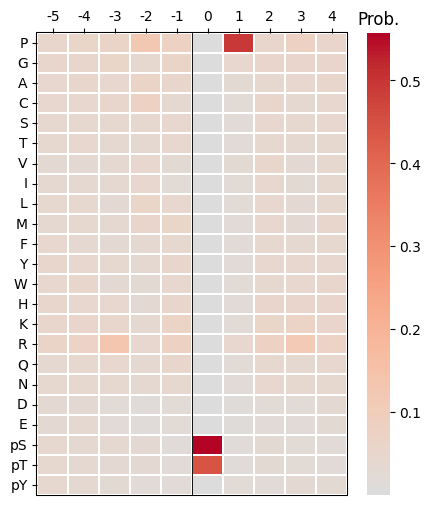

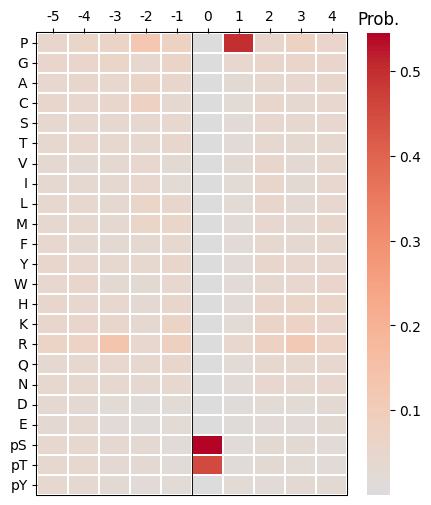

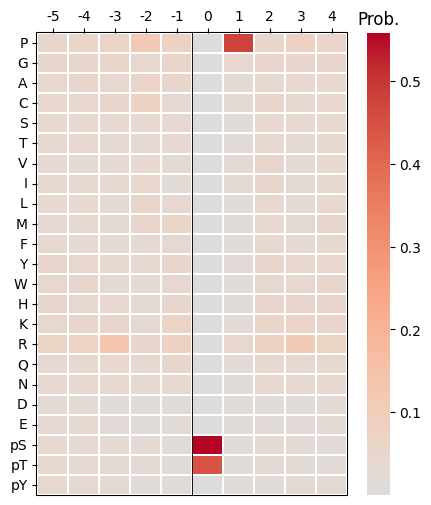

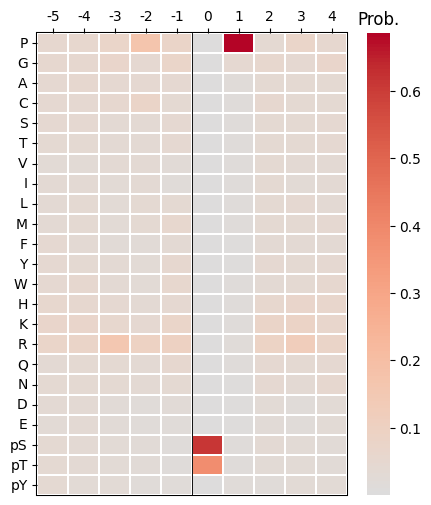

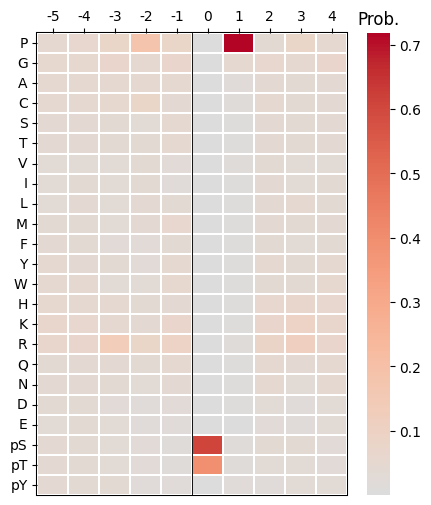

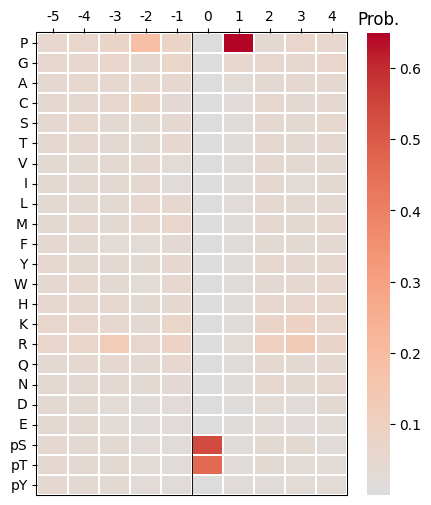

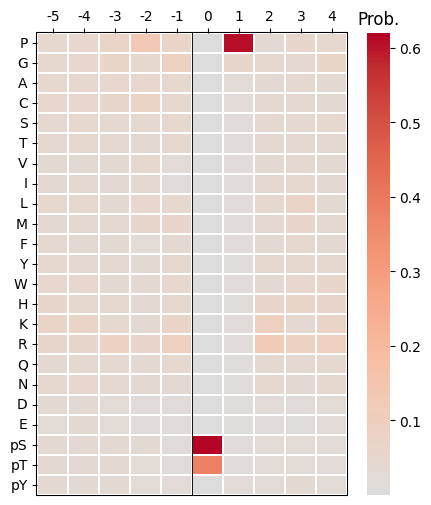

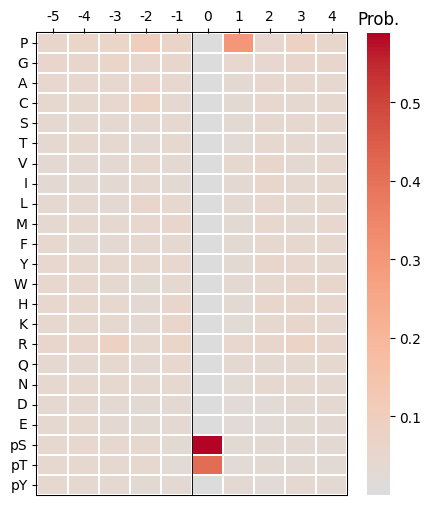

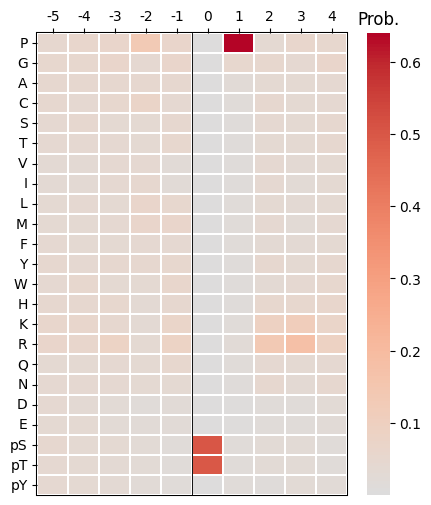

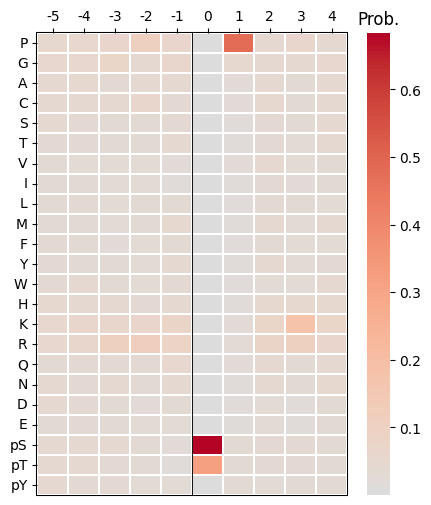

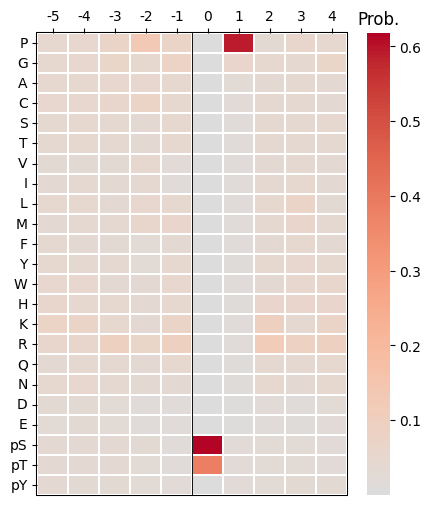

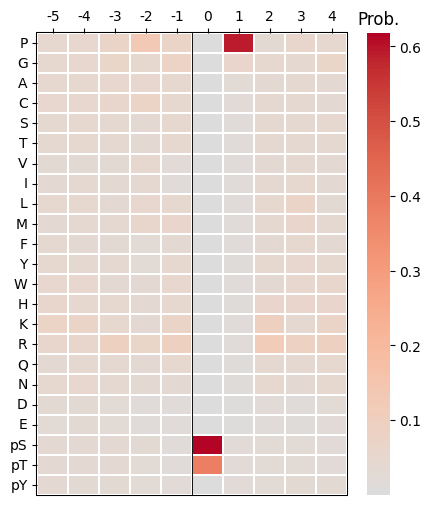

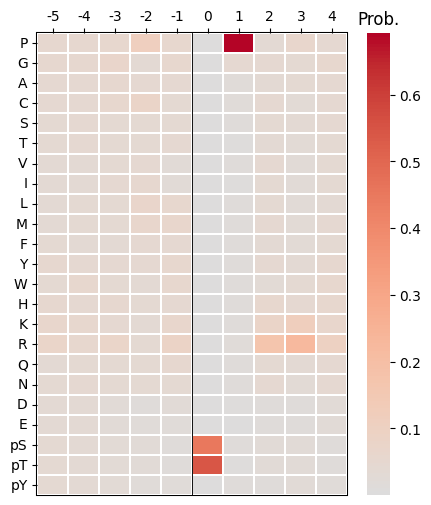

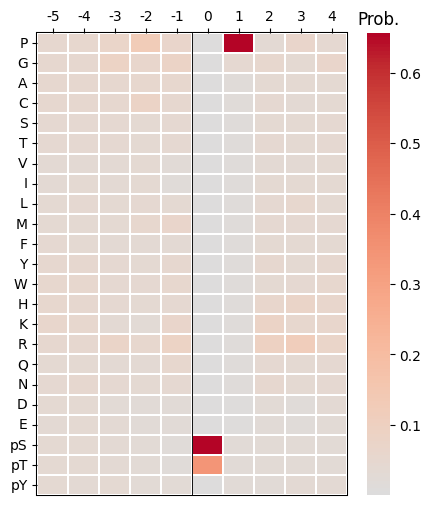

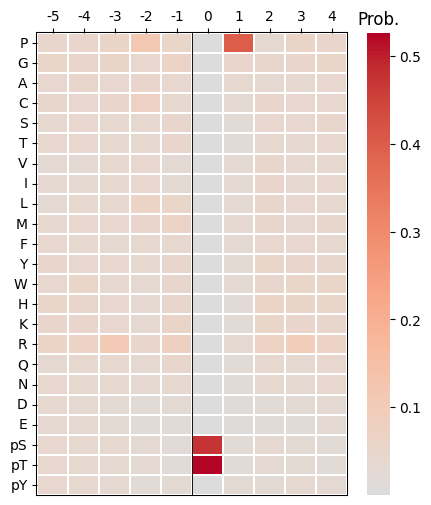

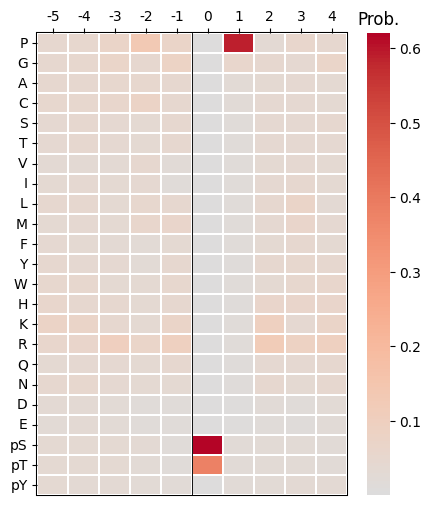

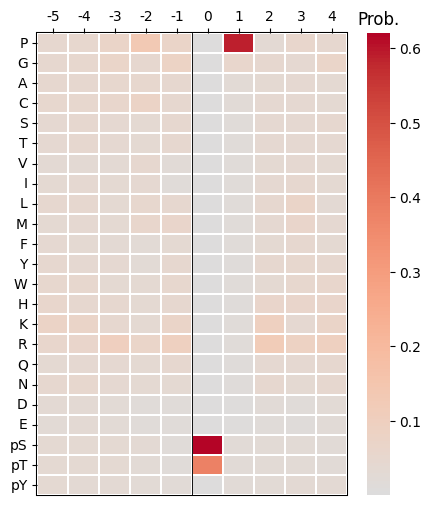

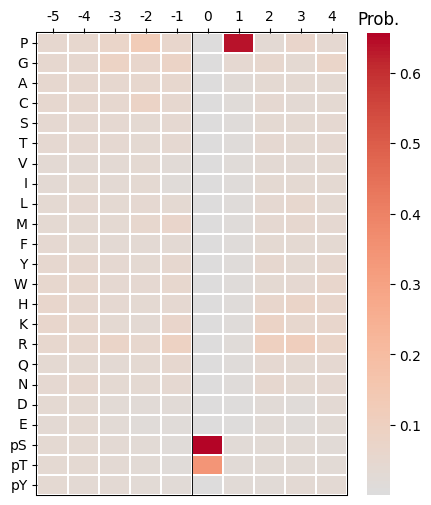

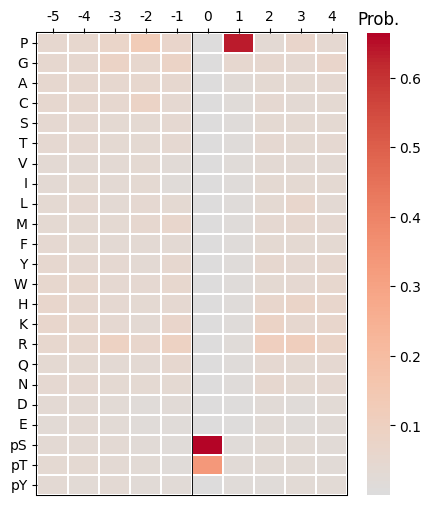

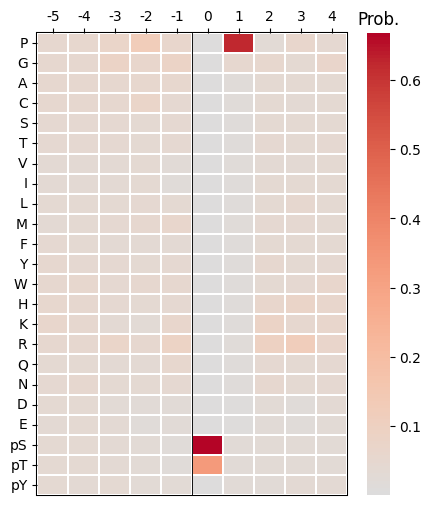

In [104]:
for i in cdks.head(20).index:
    plot_heatmap(recover_pssm(pred.loc[i]))
    plt.show()
    plt.close()